# Imports

In [1]:
import pandas as pd
import nltk
import re
import gensim
import matplotlib.pyplot as plt 
import seaborn as sns
import pyLDAvis.gensim 
import numpy as np

In [2]:
# # prevent file path leaks
# import multiprocessing
# multiprocessing.set_start_method('forkserver', force=True)

# Part 1: Inspect Data for Missing or Duplicated Data

In [3]:
df = pd.read_csv("data/multiple_subreddits_4812_posts.csv")

# check for missing values
print("missing values per column:\\n", df.isnull().sum())
# drop rows where 'Text' is empty
df = df[df["Text"].str.strip() != ""]
# check for duplicates (based on title + text)
df.drop_duplicates(subset=["Title", "Text"], inplace=True)

# save cleaned data
df.to_csv("data/subreddits_cleaned.csv", index=False)
print(f"cleaned dataset saved: {len(df)} posts")

missing values per column:\n Subreddit       0
Title           0
Text         1652
Upvotes         0
Comments        0
Timestamp       0
URL             0
dtype: int64
cleaned dataset saved: 3738 posts


# Combine The Datasets Into a File

In [4]:
# csv_files = ["data/stocks_raw_879_posts.csv"]
# df_list = [pd.read_csv(file) for file in csv_files]
# df = pd.concat(df_list, ignore_index=True)

# df.drop_duplicates(subset=["Title", "Text"], inplace=True)

# df.to_csv("data/stocks_combined.csv", index=False)
# print(f"combined dataset saved: {len(df)} posts")

# Part 2: Preprocessing

In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

df = pd.read_csv("data/subreddits_cleaned.csv")

# preprocessing function
def preprocess_text(text):
    if pd.isnull(text):  # handle missing values
        return ""

    text = text.lower()
    text = re.sub(r'http\\S+', '', text)
    text = re.sub(r'[^a-z\\s]', '', text)
    tokens = word_tokenize(text)  # tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')] 
    return " ".join(tokens)

# apply preprocessing to the "Text" column
df["Cleaned_Text"] = df["Text"].astype(str).apply(preprocess_text)

# save the cleaned dataset
df.to_csv("data/stocks_preprocessed.csv", index=False)
print(f"preprocessing complete! cleaned dataset saved: {len(df)} posts")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ullaangell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ullaangell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


preprocessing complete! cleaned dataset saved: 3738 posts


# Part 3: Model

In [7]:
from gensim import corpora
from gensim.models import LdaModel

df = pd.read_csv("data/stocks_preprocessed.csv")
# Ensure 'Cleaned_Text' is treated as a string and handle NaN values
df["Cleaned_Text"] = df["Cleaned_Text"].fillna("").astype(str)

# Now tokenize safely
df["Tokenized"] = df["Cleaned_Text"].apply(lambda x: x.split())

# Create dictionary & corpus
dictionary = corpora.Dictionary(df["Tokenized"])
corpus = [dictionary.doc2bow(text) for text in df["Tokenized"]]

# training‼️ (adjust num_topics for different results)
num_topics = 3  # number of topics
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     alpha='auto',
                     eta='auto',
                     passes=1000) # ✨the model✨

# topics with word weights
for idx, topic in lda_model.print_topics():
    print(f"\n💡 topic {idx}:\n {topic}")

# topics without weightss
print("\n💡💡💡top words in each topic:")
for topic_id, words in lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False):
    word_list = [word[0] for word in words]
    print(f"💡 topic {topic_id}: {', '.join(word_list)}")




💡 topic 0:
 0.000*"justthrowingawidenettoseeifthereareanyopinionsonanyotherwidelylistedbullishstockpatternsdoubletriplebottomsinvhsetcthatmightbecomplimentarytoanascendingtriangleatpatternwithinachartimjustgettingstartedwithalgosandthoughtthiswouldbeagoodstarttodevelopatickletickerlistidefwanttostartwiththeatpatternjustbecauseitissupereasyformetorecognizethemonachartevenwithoutascannersoisanyoneusingtheat\and\someotherchartpatternstodevelopascanlist" + 0.000*"iamoptimizingandtestingsomestrategiesforsakeofthisconversationletsassumethesestrategiesareasmediumfrequencystrategiesaverageholdingperiodishoursiamtryingtounderstandhowdoidecideonthestrategyoptimizationinsampleperiodandoutofsampleperiodhowmuchinsampleperiodshouldihavetherearemarketsituationslikepostcovidofpostlehmanshockswhicharealmostonceinlifetimehowdoiincludetheminmyoptimizationperiodandoutofsampletestingperiodwouldlovetohearhowpeoplethinkaboutthis" + 0.000*"imdevelopinganewlayerofanalysisformyalgoandiknowtherehastobeaneasiers

# Part 4: Visualisation

In [8]:
# visualize w/ pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)
# pyLDAvis.save_html(vis, 'lda_visualization.html')

/Users/ullaangell/Desktop/topic_modeling_project/.venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=34060) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/ullaangell/Desktop/topic_modeling_project/.venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=34060) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/ullaangell/Desktop/topic_modeling_project/.venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=34060) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/ullaangell/Desktop/topic_modeling_project/.venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=34060) is multi-threaded, use of fork() ma

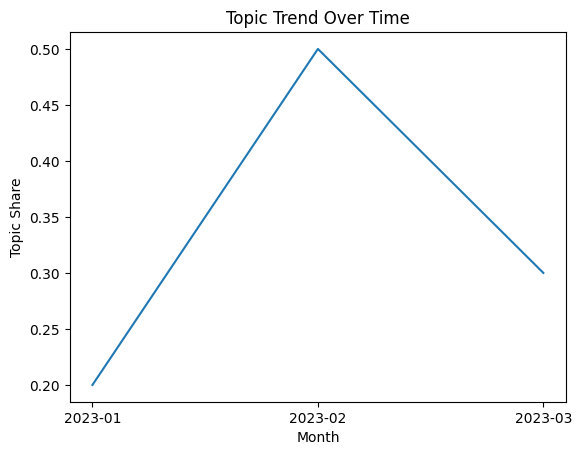

In [9]:
import matplotlib.pyplot as plt

# Example: Plotting dummy data
plt.plot(['2023-01', '2023-02', '2023-03'], [0.2, 0.5, 0.3])
plt.title("Topic Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Topic Share")
plt.show()


# Get The Topic Distribution For Each Document

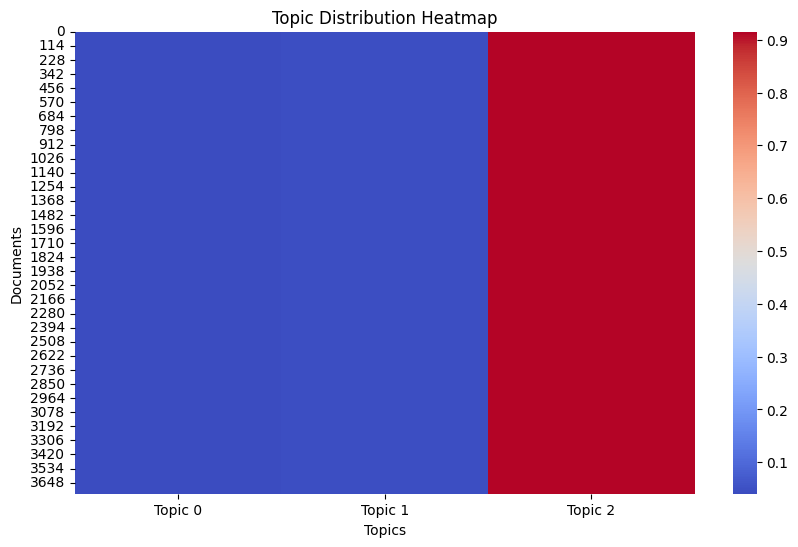

In [10]:
import numpy as np

# Get topic probabilities for each document
topic_distributions = np.array([[prob for _, prob in topic] for topic in lda_model.get_document_topics(corpus, minimum_probability=0)])

# Convert to DataFrame
topic_df = pd.DataFrame(topic_distributions, columns=[f"Topic {i}" for i in range(topic_distributions.shape[1])])

plt.figure(figsize=(10,6))
sns.heatmap(topic_df, cmap="coolwarm", annot=False)
plt.title("Topic Distribution Heatmap")
plt.xlabel("Topics")
plt.ylabel("Documents")
plt.show()


# Frequency Distribution of Word Counts in Documents

In [ ]:
# import matplotlib.colors as mcolors

# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# fig, axes = plt.subplots(2, 2, figsize=(16, 14), dpi=160, sharex=True, sharey=True)

# for i, ax in enumerate(axes.flatten()):
#     df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    
#     # Check that 'Text' is a string and then calculate document lengths
#     doc_lens = [len(d.split()) if isinstance(d, str) else 0 for d in df_dominant_topic_sub.Text]
    
#     ax.hist(doc_lens, bins=1000, color=cols[i])
#     ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    
#     # Seaborn warning fix: update `shade=False` to `fill=False`
#     sns.kdeplot(doc_lens, color="black", fill=False, ax=ax.twinx())
    
#     ax.set(xlim=(0, 1000), xlabel='Document Word Count')
#     ax.set_ylabel('Number of Documents', color=cols[i])
#     ax.set_title('Topic: ' + str(i), fontdict=dict(size=16, color=cols[i]))

# fig.tight_layout()
# fig.subplots_adjust(top=0.90)
# plt.xticks(np.linspace(0, 1000, 9))
# fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
# plt.show()
